<a href="https://colab.research.google.com/github/priyansu-debug/Data_Mining-Data_Warehouse/blob/main/Lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

datapath="/content/bank_statement_dataset.xlsx"
df=pd.read_excel(datapath)
df

,account_no,date,transaction_details,chq_no,value_date,withdrawal_amount,deposit_amount,balance_amount
0,ACC123456789,2024-01-01,Deposit 6409.82 via NEFT,NaN,2024-01-01,0.00,6409.82,56409.82
1,ACC123456789,2024-01-01,ATM Cash Withdrawal 8692.46,NaN,2024-01-01,8692.46,0.00,47717.36
2,ACC123456789,2024-01-01,ATM Cash Withdrawal 9520.45,NaN,2024-01-01,9520.45,0.00,38196.91
3,ACC123456789,2024-01-02,Deposit 1897.2 via NEFT,NaN,2024-01-02,0.00,1897.20,40094.11
4,ACC123456789,2024-01-02,ATM Cash Withdrawal 9302.58,NaN,2024-01-02,9302.58,0.00,30791.53
...,...,...,...,...,...,...,...,...
195,ACC123456789,2024-03-29,Deposit 3749.78 via NEFT,251836.0,2024-03-29,0.00,3749.78,139681.36
196,ACC123456789,2024-03-30,ATM Cash Withdrawal 8301.94,NaN,2024-03-30,8301.94,0.00,131379.42
197,ACC123456789,2024-03-30,ATM Cash Withdrawal 1551.0,NaN,2024-03-30,1551.00,0.00,129828.42
198,ACC123456789,2024-03-30,Deposit 8541.3 via NEFT,NaN,2024-03-30,0.00,8541.30,138369.72


In [ ]:
df.head()

,account_no,date,transaction_details,chq_no,value_date,withdrawal_amount,deposit_amount,balance_amount
0,ACC123456789,2024-01-01,Deposit 6409.82 via NEFT,NaN,2024-01-01,0.00,6409.82,56409.82
1,ACC123456789,2024-01-01,ATM Cash Withdrawal 8692.46,NaN,2024-01-01,8692.46,0.00,47717.36
2,ACC123456789,2024-01-01,ATM Cash Withdrawal 9520.45,NaN,2024-01-01,9520.45,0.00,38196.91
3,ACC123456789,2024-01-02,Deposit 1897.2 via NEFT,NaN,2024-01-02,0.00,1897.20,40094.11
4,ACC123456789,2024-01-02,ATM Cash Withdrawal 9302.58,NaN,2024-01-02,9302.58,0.00,30791.53


In [ ]:
df.columns

Index(['account_no', 'date', 'transaction_details', 'chq_no', 'value_date',
       'withdrawal_amount', 'deposit_amount', 'balance_amount'],
      dtype='object')

In [ ]:
df.shape

(200, 8)

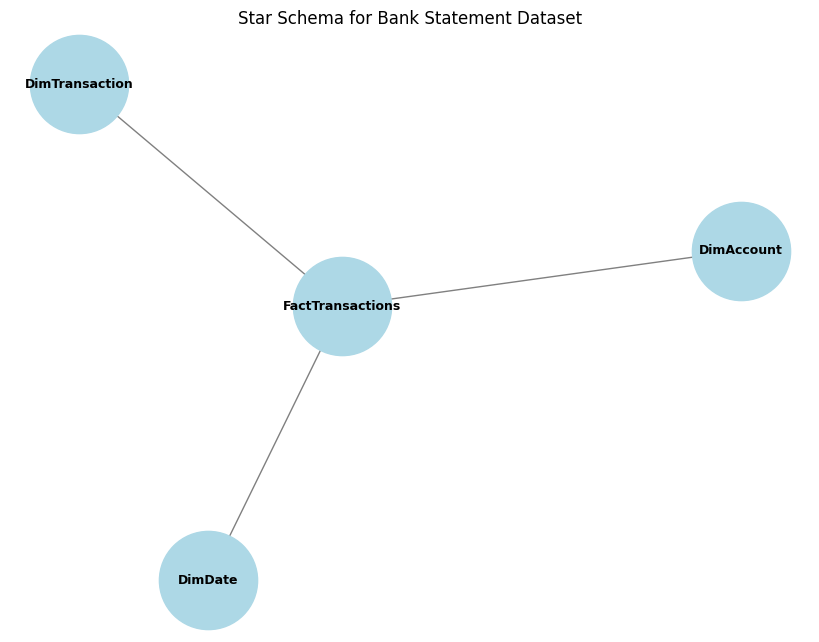

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

file_path="/content/bank_statement_dataset.xlsx"
df=pd.read_excel(file_path)

df=df.reset_index().rename(columns={"index": "TransactionID"})


dim_account=df[['account_no']].drop_duplicates().reset_index(drop=True)
dim_account['AccountID']=dim_account.index + 1

dim_date=pd.DataFrame({
    'DateID': pd.to_datetime(df['date']).astype(int) // 10*9,
    'FullDate': pd.to_datetime(df['date'])
})
dim_date['Day']=dim_date['FullDate'].dt.day
dim_date['Month']=dim_date['FullDate'].dt.month
dim_date['Quarter']=dim_date['FullDate'].dt.quarter
dim_date['Year']=dim_date['FullDate'].dt.year
dim_date=dim_date.drop_duplicates().reset_index(drop=True)

# DimTransaction
dim_transaction = df[['transaction_details', 'chq_no']].drop_duplicates().reset_index(drop=True)
dim_transaction['TransactionDetailID'] = dim_transaction.index + 1

# 3. Fact Table
fact_transactions = df[['TransactionID', 'account_no', 'date',
                        'withdrawal_amount', 'deposit_amount', 'balance_amount',
                        'transaction_details', 'chq_no']].copy()

# Map AccountID
fact_transactions = fact_transactions.merge(dim_account, on="account_no", how="left")

# Map DateID
fact_transactions = fact_transactions.merge(dim_date[['DateID', 'FullDate']],
                                            left_on=pd.to_datetime(fact_transactions['date']),
                                            right_on='FullDate', how="left").drop(columns=['FullDate'])

# Map TransactionDetailID
fact_transactions = fact_transactions.merge(dim_transaction,
                                            on=['transaction_details', 'chq_no'],
                                            how="left")

# Final Fact Table
fact_transactions = fact_transactions[['TransactionID', 'AccountID', 'DateID', 'TransactionDetailID',
                                       'withdrawal_amount', 'deposit_amount', 'balance_amount']]

# Schema dictionary
tables = {
    "FactTransactions": ["TransactionID", "AccountID", "DateID", "TransactionDetailID",
                         "WithdrawalAmount", "DepositAmount", "BalanceAmount"],
    "DimAccount": ["AccountID", "AccountNo"],
    "DimDate": ["DateID", "FullDate", "Day", "Month", "Quarter", "Year"],
    "DimTransaction": ["TransactionDetailID", "TransactionDetails", "ChequeNo"]
}

# Build Graph
G = nx.Graph()
for table in tables:
    G.add_node(table)

# Relationships (Fact ↔ Dimensions)
G.add_edge("FactTransactions", "DimAccount")
G.add_edge("FactTransactions", "DimDate")
G.add_edge("FactTransactions", "DimTransaction")

# Draw Star Schema
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightblue",
        font_size=9, font_weight="bold", edge_color="gray")
plt.title("Star Schema for Bank Statement Dataset")
plt.show()

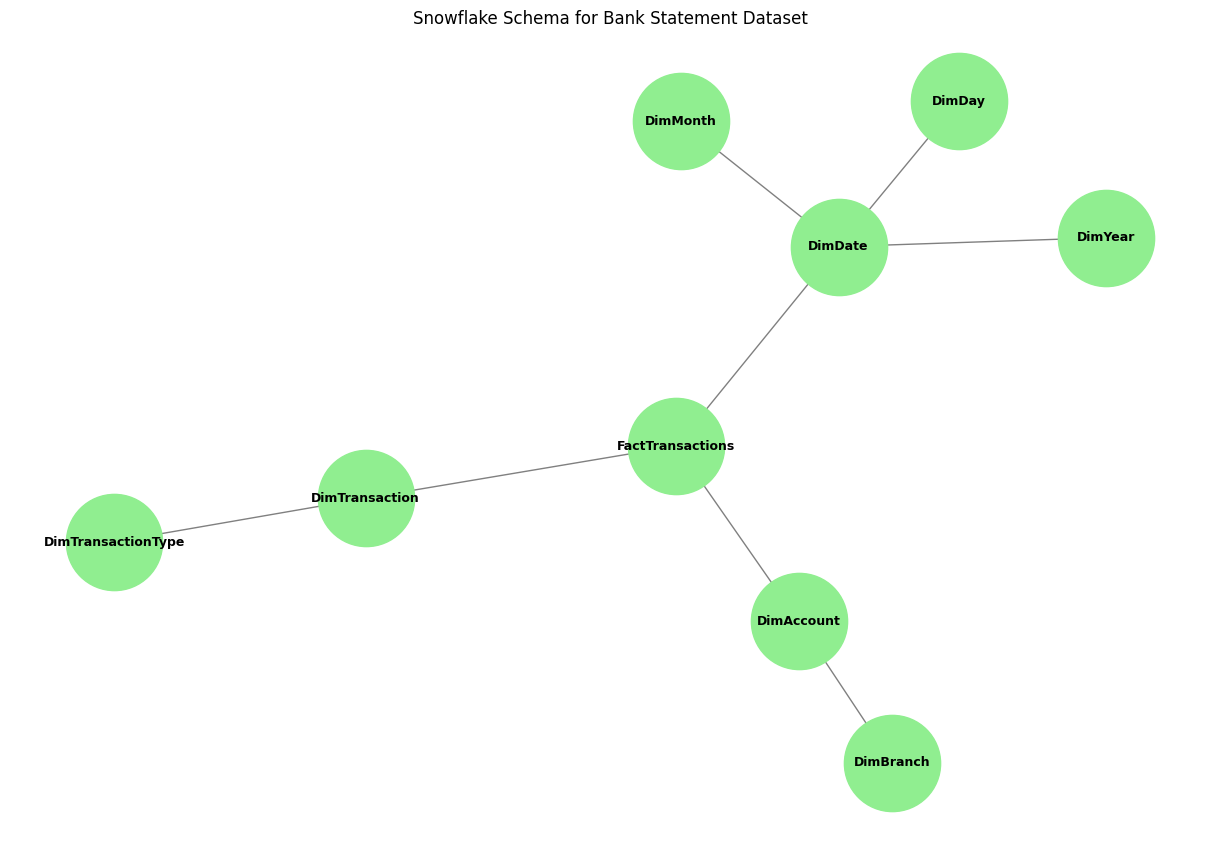

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1. Load dataset
file_path = "/content/bank_statement_dataset.xlsx"
df = pd.read_excel(file_path)

# Add TransactionID
df = df.reset_index().rename(columns={"index": "TransactionID"})

# 2. Dimension Tables

# DimAccount
dim_account = df[['account_no']].drop_duplicates().reset_index(drop=True)
dim_account['AccountID'] = dim_account.index + 1
# Fake BranchID for snowflake (since branch info missing, assign one branch for all)
dim_account['BranchID'] = 1

# DimBranch (static for now, can expand if multiple branches exist)
dim_branch = pd.DataFrame({"BranchID": [1], "BranchName": ["MainBranch"]})

# DimDate
dim_date = pd.DataFrame({
    'DateID': pd.to_datetime(df['date']).astype(int) // 10**9,
    'FullDate': pd.to_datetime(df['date'])
})
dim_date['DayID'] = dim_date['FullDate'].dt.day
dim_date['MonthID'] = dim_date['FullDate'].dt.month
dim_date['YearID'] = dim_date['FullDate'].dt.year
dim_date = dim_date.drop_duplicates().reset_index(drop=True)

# Sub-dimensions for snowflake
dim_day = dim_date[['DayID']].drop_duplicates().reset_index(drop=True)
dim_month = pd.DataFrame({
    "MonthID": range(1, 13),
    "MonthName": ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                  "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    "Quarter": [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
})
dim_year = dim_date[['YearID']].drop_duplicates().reset_index(drop=True)

# DimTransactionType
dim_transaction_type = df[['transaction_details', 'chq_no']].drop_duplicates().reset_index(drop=True)
dim_transaction_type['TransactionTypeID'] = dim_transaction_type.index + 1

# DimTransaction
dim_transaction = dim_transaction_type[['TransactionTypeID']].copy()
dim_transaction['TransactionDetailID'] = dim_transaction.index + 1

# 3. Fact Table

fact_transactions = df[['TransactionID', 'account_no', 'date',
                        'withdrawal_amount', 'deposit_amount', 'balance_amount',
                        'transaction_details', 'chq_no']].copy()

# Map AccountID
fact_transactions = fact_transactions.merge(dim_account, on="account_no", how="left")

# Map DateID
fact_transactions = fact_transactions.merge(dim_date[['DateID', 'FullDate']],
                                            left_on=pd.to_datetime(fact_transactions['date']),
                                            right_on='FullDate', how="left").drop(columns=['FullDate'])

# Map TransactionTypeID
fact_transactions = fact_transactions.merge(dim_transaction_type,
                                            on=['transaction_details', 'chq_no'],
                                            how="left")

# Map TransactionDetailID
fact_transactions = fact_transactions.merge(dim_transaction,
                                            on="TransactionTypeID", how="left")

fact_transactions = fact_transactions[['TransactionID', 'AccountID', 'DateID', 'TransactionDetailID',
                                       'withdrawal_amount', 'deposit_amount', 'balance_amount']]

# Define schema structure
tables = {
    "FactTransactions": ["TransactionID", "AccountID", "DateID", "TransactionDetailID",
                         "WithdrawalAmount", "DepositAmount", "BalanceAmount"],
    "DimAccount": ["AccountID", "AccountNo", "BranchID"],
    "DimBranch": ["BranchID", "BranchName"],
    "DimDate": ["DateID", "FullDate", "DayID", "MonthID", "YearID"],
    "DimDay": ["DayID", "DayOfMonth"],
    "DimMonth": ["MonthID", "MonthName", "Quarter"],
    "DimYear": ["YearID"],
    "DimTransaction": ["TransactionDetailID", "TransactionTypeID"],
    "DimTransactionType": ["TransactionTypeID", "TransactionDetails", "ChequeNo"]
}

# Build Graph
G = nx.Graph()
for table in tables:
    G.add_node(table)

# Relationships
G.add_edge("FactTransactions", "DimAccount")
G.add_edge("DimAccount", "DimBranch")
G.add_edge("FactTransactions", "DimDate")
G.add_edge("DimDate", "DimDay")
G.add_edge("DimDate", "DimMonth")
G.add_edge("DimDate", "DimYear")
G.add_edge("FactTransactions", "DimTransaction")
G.add_edge("DimTransaction", "DimTransactionType")

# Draw Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=4800, node_color="lightgreen",
        font_size=9, font_weight="bold", edge_color="gray")
plt.title("Snowflake Schema for Bank Statement Dataset")
plt.show()

--- Account Summary ---
     account_no  total_deposits  total_withdrawals
0  ACC123456789       532911.07          446252.49

--- Monthly Summary ---
   Year  Month  monthly_deposits  monthly_withdrawals
0  2024      1         155029.50            140043.86
1  2024      2         172372.68            123077.12
2  2024      3         205508.89            183131.51

--- Transaction Type Counts ---
             transaction_details  txn_count
0       Deposit 9871.89 via NEFT          1
1        Deposit 9832.6 via NEFT          1
2       Deposit 9810.31 via NEFT          1
3       Deposit 9709.97 via NEFT          1
4       Deposit 9667.76 via NEFT          1
..                           ...        ...
195   ATM Cash Withdrawal 1551.0          1
196  ATM Cash Withdrawal 1518.13          1
197  ATM Cash Withdrawal 1262.22          1
198   ATM Cash Withdrawal 1220.7          1
199  ATM Cash Withdrawal 1080.24          1

[200 rows x 2 columns]


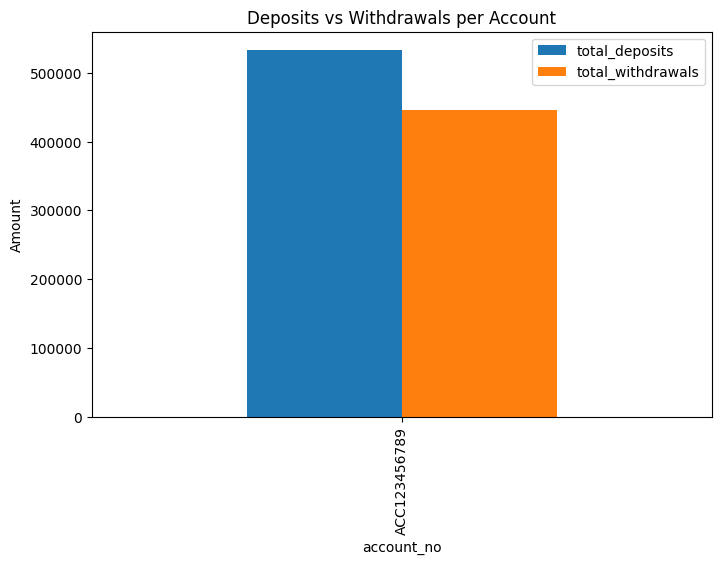

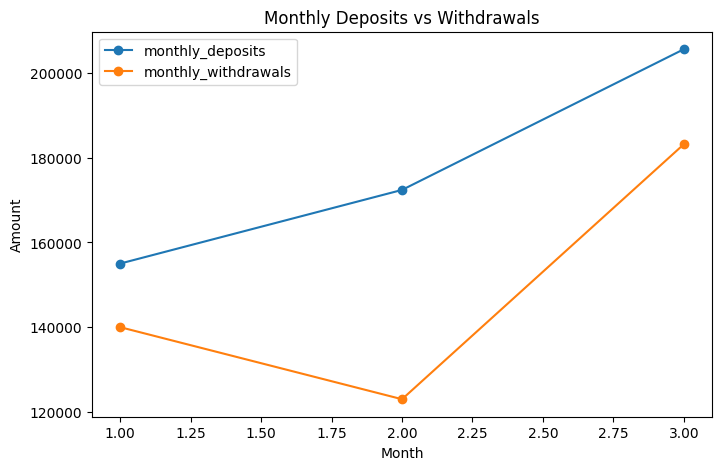

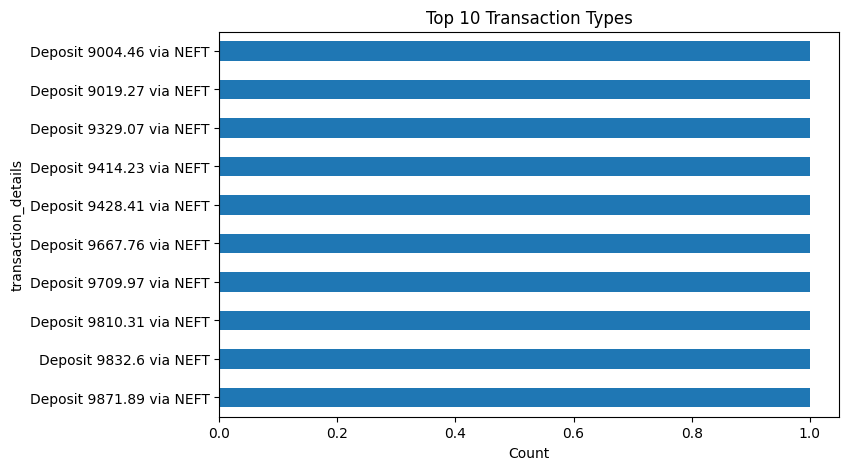

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# 1. Load dataset
file_path = "/content/bank_statement_dataset.xlsx"
df = pd.read_excel(file_path)

# Add TransactionID
df = df.reset_index().rename(columns={"index": "TransactionID"})

# 2. Create Star Schema tables

# DimAccount
dim_account = df[['account_no']].drop_duplicates().reset_index(drop=True)
dim_account['AccountID'] = dim_account.index + 1

# DimDate
dim_date = pd.DataFrame({
    'DateID': pd.to_datetime(df['date']).astype(int) // 10**9,
    'FullDate': pd.to_datetime(df['date'])
})
dim_date['Day'] = dim_date['FullDate'].dt.day
dim_date['Month'] = dim_date['FullDate'].dt.month
dim_date['Quarter'] = dim_date['FullDate'].dt.quarter
dim_date['Year'] = dim_date['FullDate'].dt.year
dim_date = dim_date.drop_duplicates().reset_index(drop=True)

# DimTransaction
dim_transaction = df[['transaction_details', 'chq_no']].drop_duplicates().reset_index(drop=True)
dim_transaction['TransactionDetailID'] = dim_transaction.index + 1

# FactTransactions
fact_transactions = df[['TransactionID', 'account_no', 'date',
                        'withdrawal_amount', 'deposit_amount', 'balance_amount',
                        'transaction_details', 'chq_no']].copy()

# Map AccountID
fact_transactions = fact_transactions.merge(dim_account, on="account_no", how="left")

# Map DateID
fact_transactions = fact_transactions.merge(dim_date[['DateID', 'FullDate']],
                                            left_on=pd.to_datetime(fact_transactions['date']),
                                            right_on='FullDate', how="left").drop(columns=['FullDate'])

# Map TransactionDetailID
fact_transactions = fact_transactions.merge(dim_transaction,
                                            on=['transaction_details', 'chq_no'], how="left")

# Final Fact table columns
fact_transactions = fact_transactions[['TransactionID', 'AccountID', 'DateID', 'TransactionDetailID',
                                     'withdrawal_amount', 'deposit_amount', 'balance_amount']]

# 3. Load into SQLite
conn = sqlite3.connect(":memory:")

dim_account.to_sql("DimAccount", conn, index=False, if_exists="replace")
dim_date.to_sql("DimDate", conn, index=False, if_exists="replace")
dim_transaction.to_sql("DimTransaction", conn, index=False, if_exists="replace")
fact_transactions.to_sql("FactTransactions", conn, index=False, if_exists="replace")

# 4. Run SQL Queries

# (a) Total Deposits and Withdrawals per Account
query1 = """
SELECT a.account_no,
       SUM(f.deposit_amount) AS total_deposits,
       SUM(f.withdrawal_amount) AS total_withdrawals
FROM FactTransactions f
JOIN DimAccount a ON f.AccountID = a.AccountID
GROUP BY a.account_no
"""
df_account_summary = pd.read_sql(query1, conn)
print("--- Account Summary ---")
print(df_account_summary)

# (b) Monthly Deposits and Withdrawals
query2 = """
SELECT d.Year, d.Month,
       SUM(f.deposit_amount) AS monthly_deposits,
       SUM(f.withdrawal_amount) AS monthly_withdrawals
FROM FactTransactions f
JOIN DimDate d ON f.DateID = d.DateID
GROUP BY d.Year, d.Month
ORDER BY d.Year, d.Month
"""
df_monthly_summary = pd.read_sql(query2, conn)
print("\n--- Monthly Summary ---")
print(df_monthly_summary)

# (c) Top Transaction Types
query3 = """
SELECT t.transaction_details,
       COUNT(*) AS txn_count
FROM FactTransactions f
JOIN DimTransaction t ON f.TransactionDetailID = t.TransactionDetailID
GROUP BY t.transaction_details
ORDER BY txn_count DESC
"""

df_txn_types = pd.read_sql(query3, conn)
print("\n--- Transaction Type Counts ---")
print(df_txn_types)

conn.close()

# 5. Visualization

# (a) Deposits vs Withdrawals per Account
df_account_summary.plot(x="account_no", y=["total_deposits", "total_withdrawals"],
                        kind="bar", figsize=(8,5))

plt.title("Deposits vs Withdrawals per Account")
plt.ylabel("Amount")
plt.show()

# (b) Monthly Deposits vs Withdrawals
df_monthly_summary.plot(x="Month", y=["monthly_deposits", "monthly_withdrawals"],
                        kind="line", marker="o", figsize=(8,5))

plt.title("Monthly Deposits vs Withdrawals")
plt.ylabel("Amount")
plt.show()

# (c) Top 10 Transaction Types
df_txn_types.head(10).plot(x="transaction_details", y="txn_count",
                          kind="barh", figsize=(8,5), legend=False)

plt.title("Top 10 Transaction Types")
plt.xlabel("Count")
plt.show()

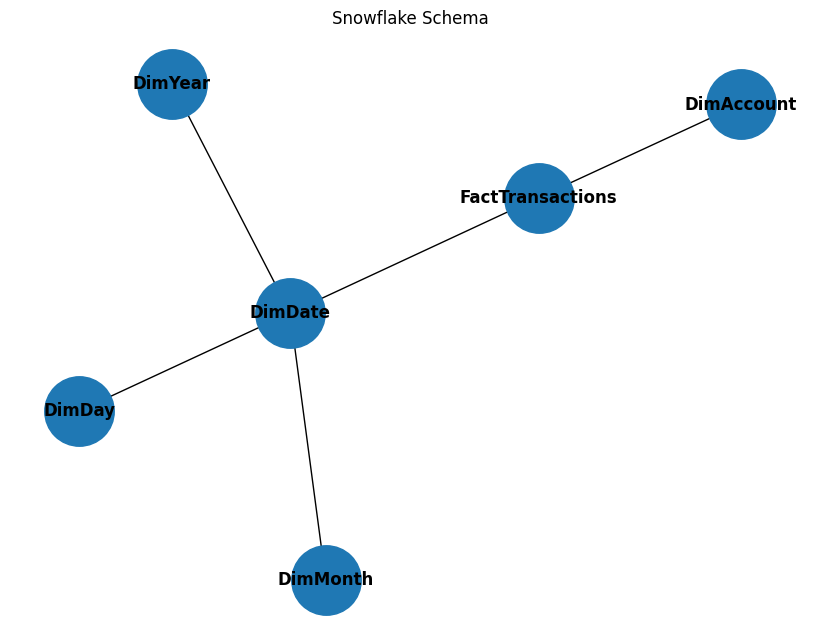

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import networkx as nx

# 1. Load dataset
file_path = "/content/bank_statement_dataset.xlsx"
df = pd.read_excel(file_path)

# 2. Create Star Schema first
dim_account = df[['account_no']].drop_duplicates().reset_index(drop=True)
dim_account['AccountID'] = dim_account.index + 1

dim_date = pd.DataFrame({'date': pd.to_datetime(df['date'])}).drop_duplicates().reset_index(drop=True)
dim_date['DateID'] = dim_date.index + 1
dim_date['Day'] = dim_date['date'].dt.day
dim_date['Month'] = dim_date['date'].dt.month
dim_date['Year'] = dim_date['date'].dt.year

fact = df.merge(dim_account, on='account_no', how='left')
fact = fact.merge(dim_date, on='date', how='left')
fact = fact[['account_no', 'AccountID', 'DateID', 'withdrawal_amount', 'deposit_amount', 'balance_amount']]

# 3. Transform Star -> Snowflake (normalize date into separate tables)
dim_day = dim_date[['Day']].drop_duplicates().reset_index(drop=True)
dim_day['DayID'] = dim_day.index + 1

dim_month = dim_date[['Month']].drop_duplicates().reset_index(drop=True)
dim_month['MonthID'] = dim_month.index + 1

dim_year = dim_date[['Year']].drop_duplicates().reset_index(drop=True)
dim_year['YearID'] = dim_year.index + 1

# Re-link date dimension to snowflake parts
dim_date_sf = dim_date.merge(dim_day, on='Day').merge(dim_month, on='Month').merge(dim_year, on='Year')
dim_date_sf = dim_date_sf[['DateID', 'date', 'DayID', 'MonthID', 'YearID']]

# 4. Visualize Snowflake Schema
G = nx.Graph()
G.add_node("FactTransactions")
G.add_node("DimAccount")
G.add_node("DimDate")
G.add_node("DimDay")
G.add_node("DimMonth")
G.add_node("DimYear")

G.add_edge("FactTransactions", "DimAccount")
G.add_edge("FactTransactions", "DimDate")
G.add_edge("DimDate", "DimDay")
G.add_edge("DimDate", "DimMonth")
G.add_edge("DimDate", "DimYear")

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, font_weight='bold')
plt.title("Snowflake Schema")
plt.show()